In [1]:
# %pip install shap ipywidgets

In [2]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
from dataclasses import dataclass, field
import matplotlib.pyplot as plt
import io
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import torch
import numpy as np

import tqdm
from utils import restore_checkpoint
sns.set(font_scale=2)
sns.set(style="whitegrid")

import models
from models import utils as mutils
from models import ncsnpp
import sampling
from likelihood import get_likelihood_fn
from sde_lib import VESDE, VPSDE, subVPSDE
from sampling import EulerMaruyamaPredictor
import datasets

# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only use the first GPU
#   try:
#     tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
#   except RuntimeError as e:
#     # Visible devices must be set before GPUs have been initialized
#     print(e)



In [3]:
from configs.subvp import mvtec_ncsnpp_continuous as configs
config = configs.get_config()
config

data:
  category: hazelnut
  centered: true
  dataset: MVTEC
  dir_path: /DATA/Users/amahmood/GDrive/MVTec_AD/
  downsample_size: 200
  image_size: 128
  num_channels: 3
  random_flip: true
  uniform_dequantization: false
device: !!python/object/apply:torch.device
- cuda
- 0
eval:
  batch_size: 16
  begin_ckpt: 3
  bpd_dataset: inlier
  enable_bpd: true
  enable_loss: true
  enable_sampling: false
  end_ckpt: 3
  num_samples: 50000
  ood_eval: true
model:
  attention_type: ddpm
  attn_resolutions: !!python/tuple
  - 16
  beta_max: 20.0
  beta_min: 0.1
  ch_mult: !!python/tuple
  - 1
  - 2
  - 2
  - 2
  conditional: true
  conv_size: 3
  dropout: 0.0
  ema_rate: 0.9999
  embedding_type: positional
  fir: true
  fir_kernel:
  - 1
  - 3
  - 3
  - 1
  fourier_scale: 16
  init_scale: 0.0
  name: ncsnpp
  nf: 64
  nonlinearity: swish
  normalization: GroupNorm
  num_res_blocks: 4
  num_scales: 2000
  progressive: none
  progressive_combine: sum
  progressive_input: residual
  resamp_with_con

In [4]:
# Setup SDE
import sde_lib
sde = sde_lib.subVPSDE(
    beta_min=config.model.beta_min,
    beta_max=config.model.beta_max,
    N=config.model.num_scales,
)
sampling_eps = 1e-3


def noise_schedule_inverse(sigma):
    """
    Returns the timepoint at which the sigma is observed
    according to the subVPSDE schedule
    This is simply the solution obtained via the quadratic formula for the 
    std calculation for a subVPSDE (b24ac => b^2 - 4ac)
    """
    b = sde.beta_0
    b24ac = b ** 2 - 2 * (sde.beta_1 - sde.beta_0) * torch.log(1 - sigma + 1e-12)
    t = (-b + b24ac ** 0.5) / (sde.beta_1 - sde.beta_0)
    return torch.clip(t, max=1.0)

In [5]:
# @title Load the score-based model
from configs.subvp import mvtec_ncsnpp_continuous as configs
from losses import get_optimizer
from models.ema import ExponentialMovingAverage

ckpt_filename = f"workdir/mvtec/checkpoints-meta/checkpoint.pth"
config = configs.get_config()
sde = subVPSDE(beta_min=config.model.beta_min, beta_max=config.model.beta_max, N=config.model.num_scales)

sigmas = mutils.get_sigmas(config)
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)
score_model = mutils.create_model(config)

optimizer = get_optimizer(config, score_model.parameters())
ema = ExponentialMovingAverage(score_model.parameters(),
                               decay=config.model.ema_rate)
state = dict(step=0, optimizer=optimizer,
             model=score_model, ema=ema)

state = restore_checkpoint(ckpt_filename, state, config.device)
ema.copy_to(score_model.parameters())

score_fn = mutils.get_score_fn(sde, score_model, train=False,
                               continuous=config.training.continuous)

In [6]:
N_TIMESTEPS = 32
n_timesteps=N_TIMESTEPS
eps=1e-3
msma_sigmas = torch.linspace(eps, 1.0, n_timesteps, device="cuda")
timesteps = noise_schedule_inverse(msma_sigmas)
msma_sigmas, timesteps

(tensor([0.0010, 0.0332, 0.0655, 0.0977, 0.1299, 0.1621, 0.1944, 0.2266, 0.2588,
         0.2910, 0.3233, 0.3555, 0.3877, 0.4199, 0.4522, 0.4844, 0.5166, 0.5488,
         0.5811, 0.6133, 0.6455, 0.6777, 0.7100, 0.7422, 0.7744, 0.8066, 0.8389,
         0.8711, 0.9033, 0.9355, 0.9678, 1.0000], device='cuda:0'),
 tensor([0.0062, 0.0535, 0.0776, 0.0967, 0.1133, 0.1284, 0.1424, 0.1557, 0.1685,
         0.1810, 0.1931, 0.2051, 0.2171, 0.2290, 0.2410, 0.2530, 0.2653, 0.2778,
         0.2907, 0.3040, 0.3179, 0.3324, 0.3477, 0.3641, 0.3819, 0.4014, 0.4233,
         0.4488, 0.4796, 0.5199, 0.5826, 1.0000], device='cuda:0'))

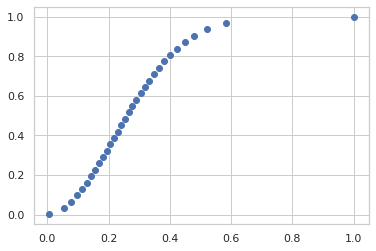

In [7]:
plt.scatter(timesteps.cpu(), msma_sigmas.cpu(), )

In [15]:
x_dummy = torch.ones((1,3,48,48), dtype=torch.float32, device=config.device)
t_dummy = torch.ones(1, device=config.device) * 0.5

In [11]:
torch.__version__

'1.11.0a0+b6df043'

In [17]:
#score_fn(x_dummy, t_dummy)

In [8]:
import pathlib
import tensorflow as tf
import tensorflow_datasets as tfds
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

RANDOM_SEED = 42
dataset_dir = f"{config.data.dir_path}/{config.data.category}"
dataset_builder = tfds.ImageFolder(dataset_dir)

train_dir = pathlib.Path(f"{dataset_dir}/train/")
test_dir = pathlib.Path(f"{dataset_dir}/test/")
seg_dir = pathlib.Path(f"{dataset_dir}/ground_truth/")
print(train_dir, test_dir, seg_dir, sep="\n")

LABELS = sorted(os.listdir(f"{test_dir}"))
ANO_LABELS = [x for x in LABELS if x != "good"]
ANO_LABELS_IDX = [LABELS.index(x) for x in ANO_LABELS]
INLIER_LABEL = LABELS.index("good")
print(LABELS, INLIER_LABEL, ANO_LABELS, ANO_LABELS_IDX)

image_count = len(list(train_dir.glob('*/*.png')))
print("Training Images:", image_count)
image_count = len(list(test_dir.glob('*/*.png')))
print("Testing Images:", image_count)
image_count = len(list(seg_dir.glob('*/*.png')))
print("Anomalous Images:", image_count)

2022-02-17 20:49:01.536355: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/train
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/test
/DATA/Users/amahmood/GDrive/MVTec_AD/hazelnut/ground_truth
['crack', 'cut', 'good', 'hole', 'print'] 2 ['crack', 'cut', 'hole', 'print'] [0, 1, 3, 4]
Training Images: 391
Testing Images: 110
Anomalous Images: 70


In [94]:
x.numpy().ndim

4

In [120]:
def load_sample(x, scale=True):
  if isinstance(x, tf.Tensor):
    x = x.numpy()
  if x.ndim == 3:
    x = np.expand_dims(x, axis=0)
  with torch.no_grad():
    x_tensor = torch.from_numpy(x).to(config.device).float()
    if scale:
        x_tensor = scaler(x_tensor)
    x_tensor = x_tensor.permute(0, 3, 1, 2)
    return x_tensor

@tf.function
def preproc(x, y):
    return x/255, y

def build_ds_loaders(img_w, img_h, bs):

    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_dir,
        seed=RANDOM_SEED,
        shuffle=False,
        image_size=(img_w, img_h),
        batch_size=bs
    ).map(preproc)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_dir,
        class_names=LABELS,
        seed=RANDOM_SEED,
        shuffle=False,
        image_size=(img_w, img_h),
        batch_size=bs
    ).map(preproc)

    seg_ds = tf.keras.preprocessing.image_dataset_from_directory(
        seg_dir,
        class_names=ANO_LABELS,
        seed=RANDOM_SEED,
        shuffle=False,
        image_size=(img_w, img_h),
        batch_size=bs
    ).map(preproc)

    return train_ds, test_ds, seg_ds

train_ds, test_ds, seg_ds = build_ds_loaders(128, 128, bs=128)

Found 392 files belonging to 1 classes.
Found 110 files belonging to 5 classes.
Found 70 files belonging to 4 classes.


In [25]:
x_train = tf.concat([x_batch for x_batch, _ in train_ds], axis=0)
x_train.shape

TensorShape([392, 128, 128, 3])

In [87]:
isinstance(x_train, tf.Tensor)

True

In [86]:
type(x_train)

tensorflow.python.framework.ops.EagerTensor

In [26]:
x_test, test_labels = next(iter(test_ds))
x_ood_segs, seg_labels = next(iter(seg_ds))
x_ood = x_test[test_labels != INLIER_LABEL]
x_inlier = x_test[test_labels == INLIER_LABEL]

In [27]:
x = x_train[:1]
x.shape

TensorShape([1, 128, 128, 3])

torch.Size([1, 3, 128, 128])


/tmp/ipykernel_57495/64305291.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


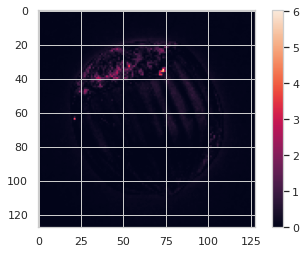

In [28]:
t = 1.0
with torch.no_grad():
  vec_t = torch.ones(1, device=config.device) * t
  x_tensor = load_sample(x)
  
  score = score_fn(x_tensor, vec_t).cpu()

plt.imshow(score[0].permute(1, 2, 0).mean(axis=-1)**2)
plt.colorbar()
print(score.shape)

In [29]:
from tqdm import tqdm

def scorer(x):
    batch_size = x.shape[0]
    scores = torch.zeros((batch_size, n_timesteps), dtype=torch.float32)

    with torch.no_grad():
        for i in range(n_timesteps):
            t = timesteps[i]
            vec_t = torch.ones(x.shape[0], device=config.device) * t
            std = sde.marginal_prob(torch.zeros_like(x), vec_t)[1]
            score = score_fn(x, vec_t) #* std[:, None, None, None]
            scores[..., i] = torch.linalg.norm(
                              score.reshape(batch_size, -1),
                              axis=1) * std
    return scores.numpy()

In [30]:
x, x_lab = next(iter(train_ds))

In [31]:
%%time
score_norms = scorer(load_sample(x[:1]))
score_norms.shape

CPU times: user 889 ms, sys: 3.97 ms, total: 893 ms
Wall time: 892 ms


(1, 32)

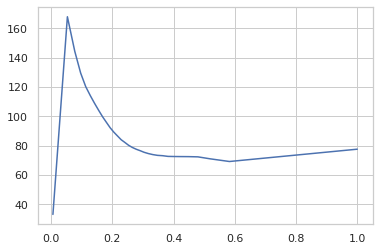

In [32]:
plt.plot(timesteps.cpu(), score_norms[0])

In [33]:
%%time

train_score_norms = []

for x_batch, x_lab in tqdm(train_ds):
    train_score_norms.append(scorer(load_sample(x_batch)))

train_score_norms = np.concatenate(train_score_norms)

100% 4/4 [01:24<00:00, 21.12s/it]

CPU times: user 27.1 s, sys: 1min 7s, total: 1min 34s
Wall time: 1min 24s


In [34]:
%%time

test_score_norms = []
test_labels = []

for x_batch, x_lab in tqdm(test_ds):
    test_score_norms.append(scorer(load_sample(x_batch)))
    test_labels.append(x_lab.numpy())

test_score_norms = np.concatenate(test_score_norms)
test_labels = np.concatenate(test_labels)

100% 1/1 [00:24<00:00, 24.02s/it]

CPU times: user 7.61 s, sys: 19.2 s, total: 26.8 s
Wall time: 24 s


In [35]:
ood_score_norms = test_score_norms[test_labels != INLIER_LABEL]
inlier_score_norms = test_score_norms[test_labels == INLIER_LABEL]

In [36]:
ez_ood_score_norms = test_score_norms[np.logical_and(test_labels != INLIER_LABEL, test_labels != 0)] #skip cracks

In [37]:
ez_ood_score_norms.shape

(52, 32)

In [38]:
train_score_norms.shape, inlier_score_norms.shape, ood_score_norms.shape

((392, 32), (40, 32), (70, 32))

In [39]:
recordify = lambda ds,name: [(msma_sigmas[i].item(), x**1, name) for i, scores in enumerate(ds.T) for x in scores ]

train_recs = recordify(train_score_norms, "train")
inlier_recs = recordify(inlier_score_norms, "inlier")
ood_recs = recordify(ood_score_norms, "ood")
ez_ood_recs = recordify(ez_ood_score_norms, "ez-ood")

df = pd.DataFrame.from_records(train_recs+inlier_recs+ood_recs + ez_ood_recs, columns=["sigma", "score", "dataset"])
df

sigma      score dataset
0      0.001  33.049492   train
1      0.001  33.416679   train
2      0.001  32.809856   train
3      0.001  31.907421   train
4      0.001  32.484573   train
...      ...        ...     ...
17723  1.000  86.354904  ez-ood
17724  1.000  80.140434  ez-ood
17725  1.000  85.291626  ez-ood
17726  1.000  81.216217  ez-ood
17727  1.000  88.945526  ez-ood

[17728 rows x 3 columns]

<AxesSubplot:xlabel='sigma', ylabel='score'>

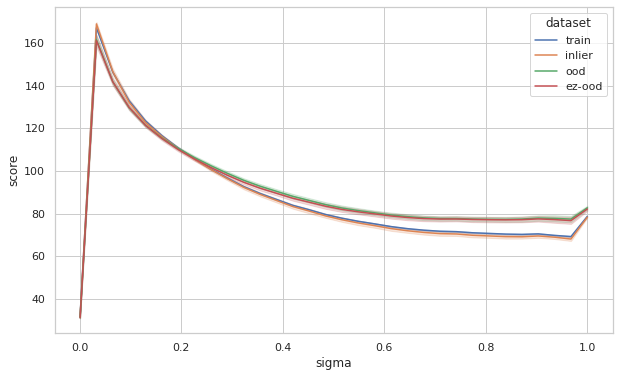

In [40]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
sns.lineplot(data=df, x="sigma", y="score", hue="dataset", ci=95, ax=ax)

<AxesSubplot:xlabel='sigma', ylabel='score'>

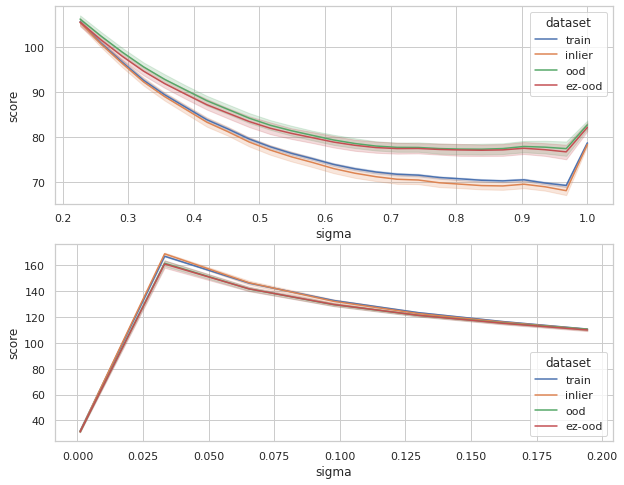

In [41]:
fig, ax = plt.subplots(2,1, figsize=(10,8))
sns.lineplot(data=df.query('sigma>0.2'), x="sigma", y="score", hue="dataset", ci=95, ax=ax[0])
sns.lineplot(data=df.query('sigma<0.2'), x="sigma", y="score", hue="dataset", ci=95, ax=ax[1])
# plt.ylim(100,None)

## Visualizing Scores

In [223]:
def compute_score_tensors(X, nsamples=4, nsigmas=10):
    xt = tf.concat([x for x,_ in X.take(nsamples)], axis=0)
    x = load_sample(xt)
    scores = torch.zeros((*x.shape, nsigmas+1), dtype=torch.float32)
    scores[..., 0] = x.cpu()
    
    with torch.no_grad():
        for i in range(0, nsigmas):
            t = timesteps[i*nsigmas]
            vec_t = torch.ones(x.shape[0], device=config.device) * t
            std = sde.marginal_prob(torch.zeros_like(x), vec_t)[1]
            score = score_fn(x, vec_t) * std[:, None, None, None]
            scores[..., i+1] = score.cpu()
            
    return scores.numpy()

In [191]:
train_ds, test_ds, seg_ds = build_ds_loaders(128, 128, bs=1)

Found 392 files belonging to 1 classes.
Found 110 files belonging to 5 classes.
Found 70 files belonging to 4 classes.


In [177]:
test_labels.shape

(110,)

In [212]:
ood_print = test_ds.filter(lambda x, lab: tf.reduce_all(lab == 4))

In [224]:
%%time
print_scores = compute_score_tensors(ood_print)

CPU times: user 7.01 s, sys: 605 ms, total: 7.61 s
Wall time: 833 ms


In [225]:
print_scores.shape

(4, 3, 128, 128, 11)

In [236]:
from IPython import display
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from scipy.ndimage import (
    maximum_filter,
    percentile_filter,
    uniform_filter,
    median_filter,
    gaussian_filter)

def plot_scores(scores, sigmas, num_samples=5, original_included=False, vmax=None,
                thresh_q=None, cmap="rocket", smooth = False):

  n_sigmas = sigmas.shape[0]
  cols = scores.shape[1]
  fig = plt.figure(figsize=(4*cols, 4*num_samples))
  grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(num_samples, cols),  # creates grid of axes
                    direction="row",
                    axes_pad=0.25,  # pad between axes in inch.
                    share_all=True,
                    cbar_location="right",
                    cbar_mode="each",
                    cbar_size="3%",
                    cbar_pad="1%",
                    label_mode = "1"
                    )
  scores = np.concatenate(scores[:num_samples, ...])
  for i, (ax, cax, s) in enumerate(zip(grid, grid.cbar_axes, scores)):
      # Iterating over the grid returns the Axes.
      
      _vmax = vmax
      _cmap = cmap

      if original_included and i % cols == 0:
        _cmap=None
        _vmax = None
        im = inverse_scaler(s)
      else:
        im = s ** 2

      if i % cols > 0 or not original_included:
        if im.shape[-1] > 1:
            im = np.mean(im, axis=-1)
        
        if thresh_q:
          thresh = np.quantile(im, thresh_q)
          im [im < thresh] = 0
        if smooth:
          im = gaussian_filter(im, sigma=1.0, mode="constant")
#           im = uniform_filter(im, 7)
        

      im = ax.imshow(im, cmap=_cmap, vmax=_vmax)
      fig.colorbar(im, cax=cax)
      ax.grid(False)
      
      if original_included:
        if i > 0 and i <= n_sigmas:
          ax.set_title(f"s={sigmas[i-1]:.3f}", fontsize=14)
      elif i < n_sigmas:
        ax.set_title(f"s={sigmas[i]:.3f}", fontsize=14)

  plt.show()
  return

In [230]:
viz_tensors = np.transpose(print_scores,[0,4,2,3,1])
viz_tensors.shape

(4, 11, 128, 128, 3)

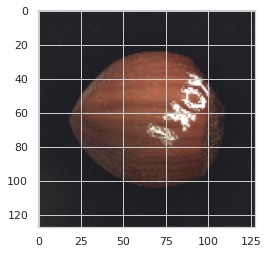

In [235]:
plt.imshow(0.5*(viz_tensors[0,0]+1))

/tmp/ipykernel_64900/2117256981.py:55: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax)


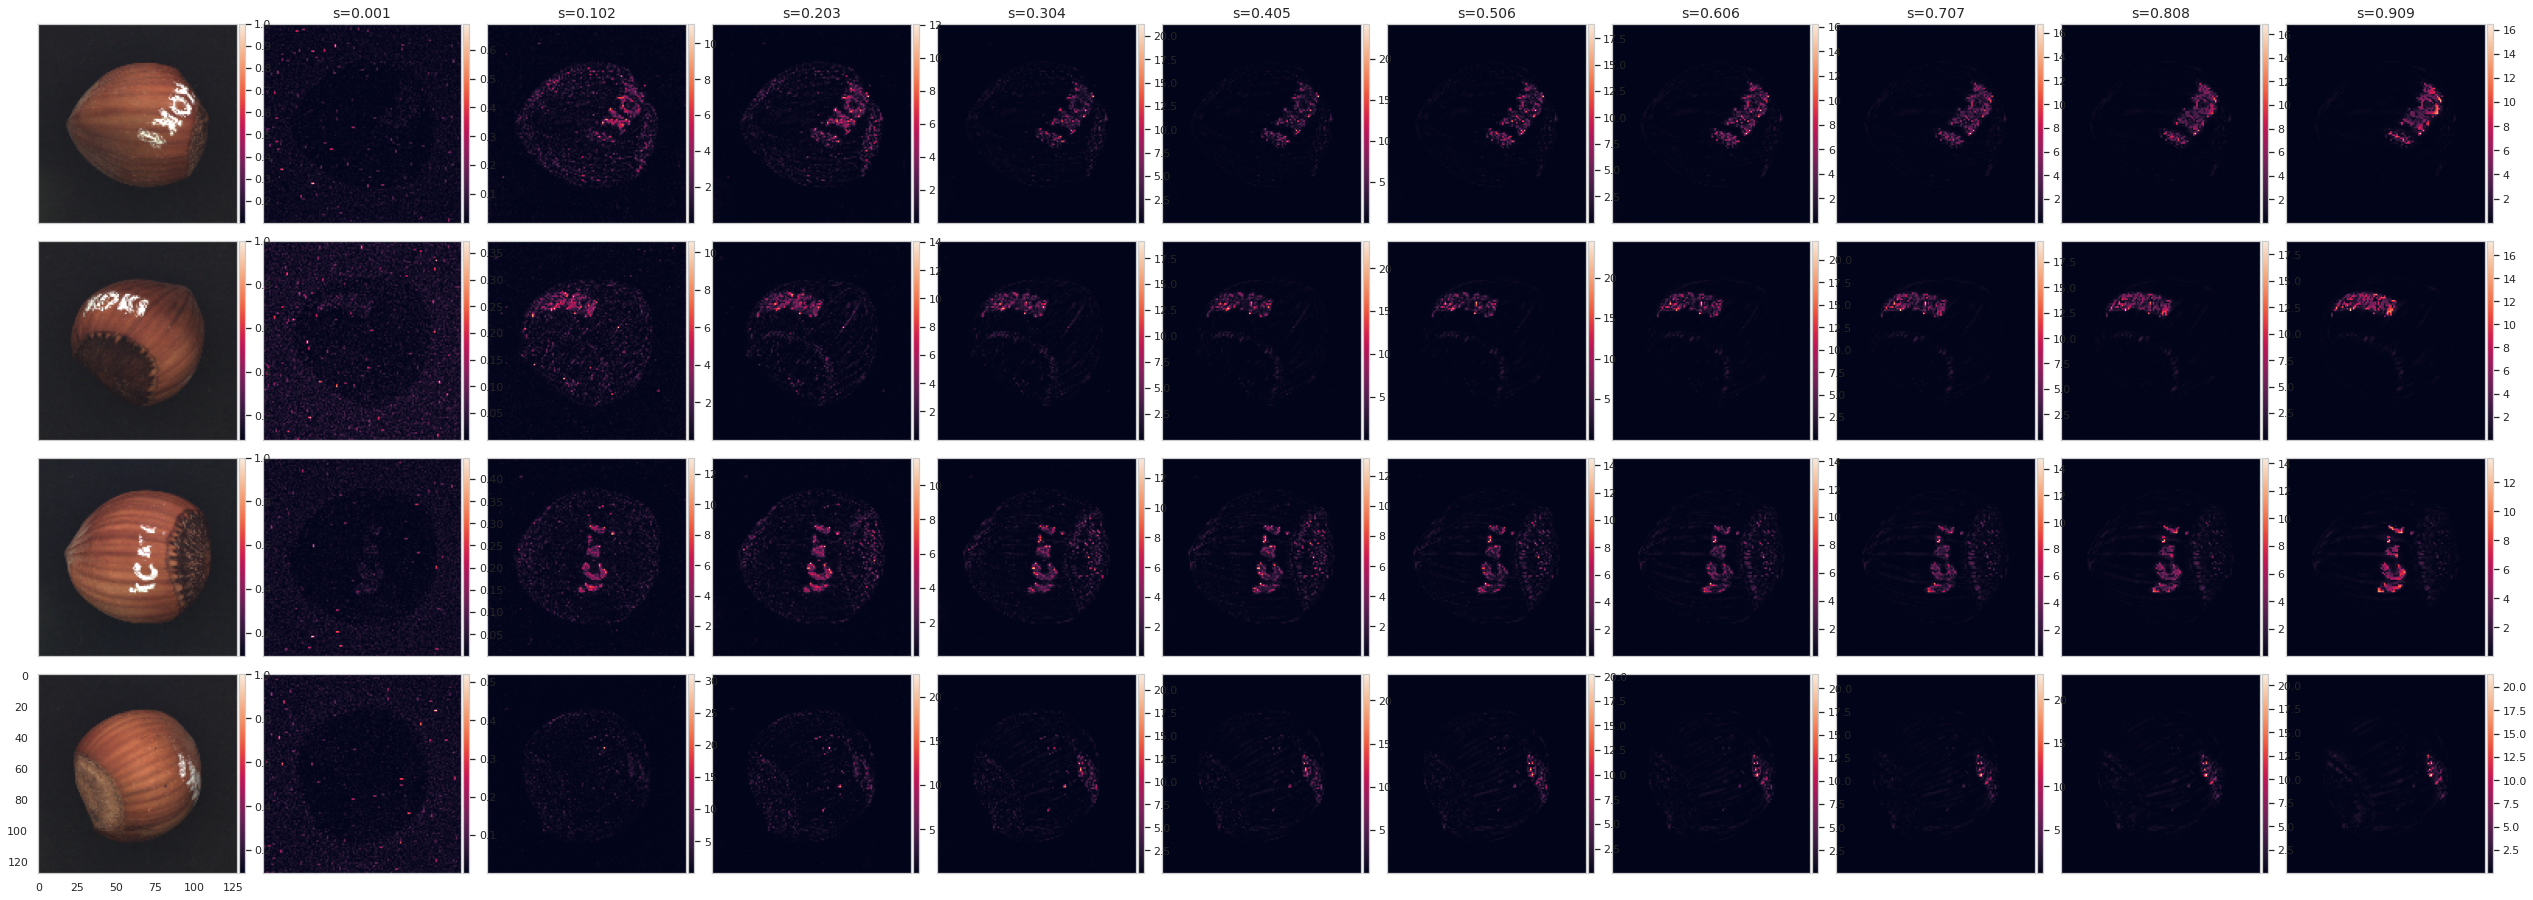

In [237]:
plot_scores(viz_tensors, msma_sigmas[::10],  num_samples=4, original_included=True)

In [48]:
viz_ood = np.transpose(ood_scores,[1,0,3,4,2])
viz_ood.shape

(70, 10, 128, 128, 3)

/tmp/ipykernel_480/3372817621.py:53: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(im, cax=cax)


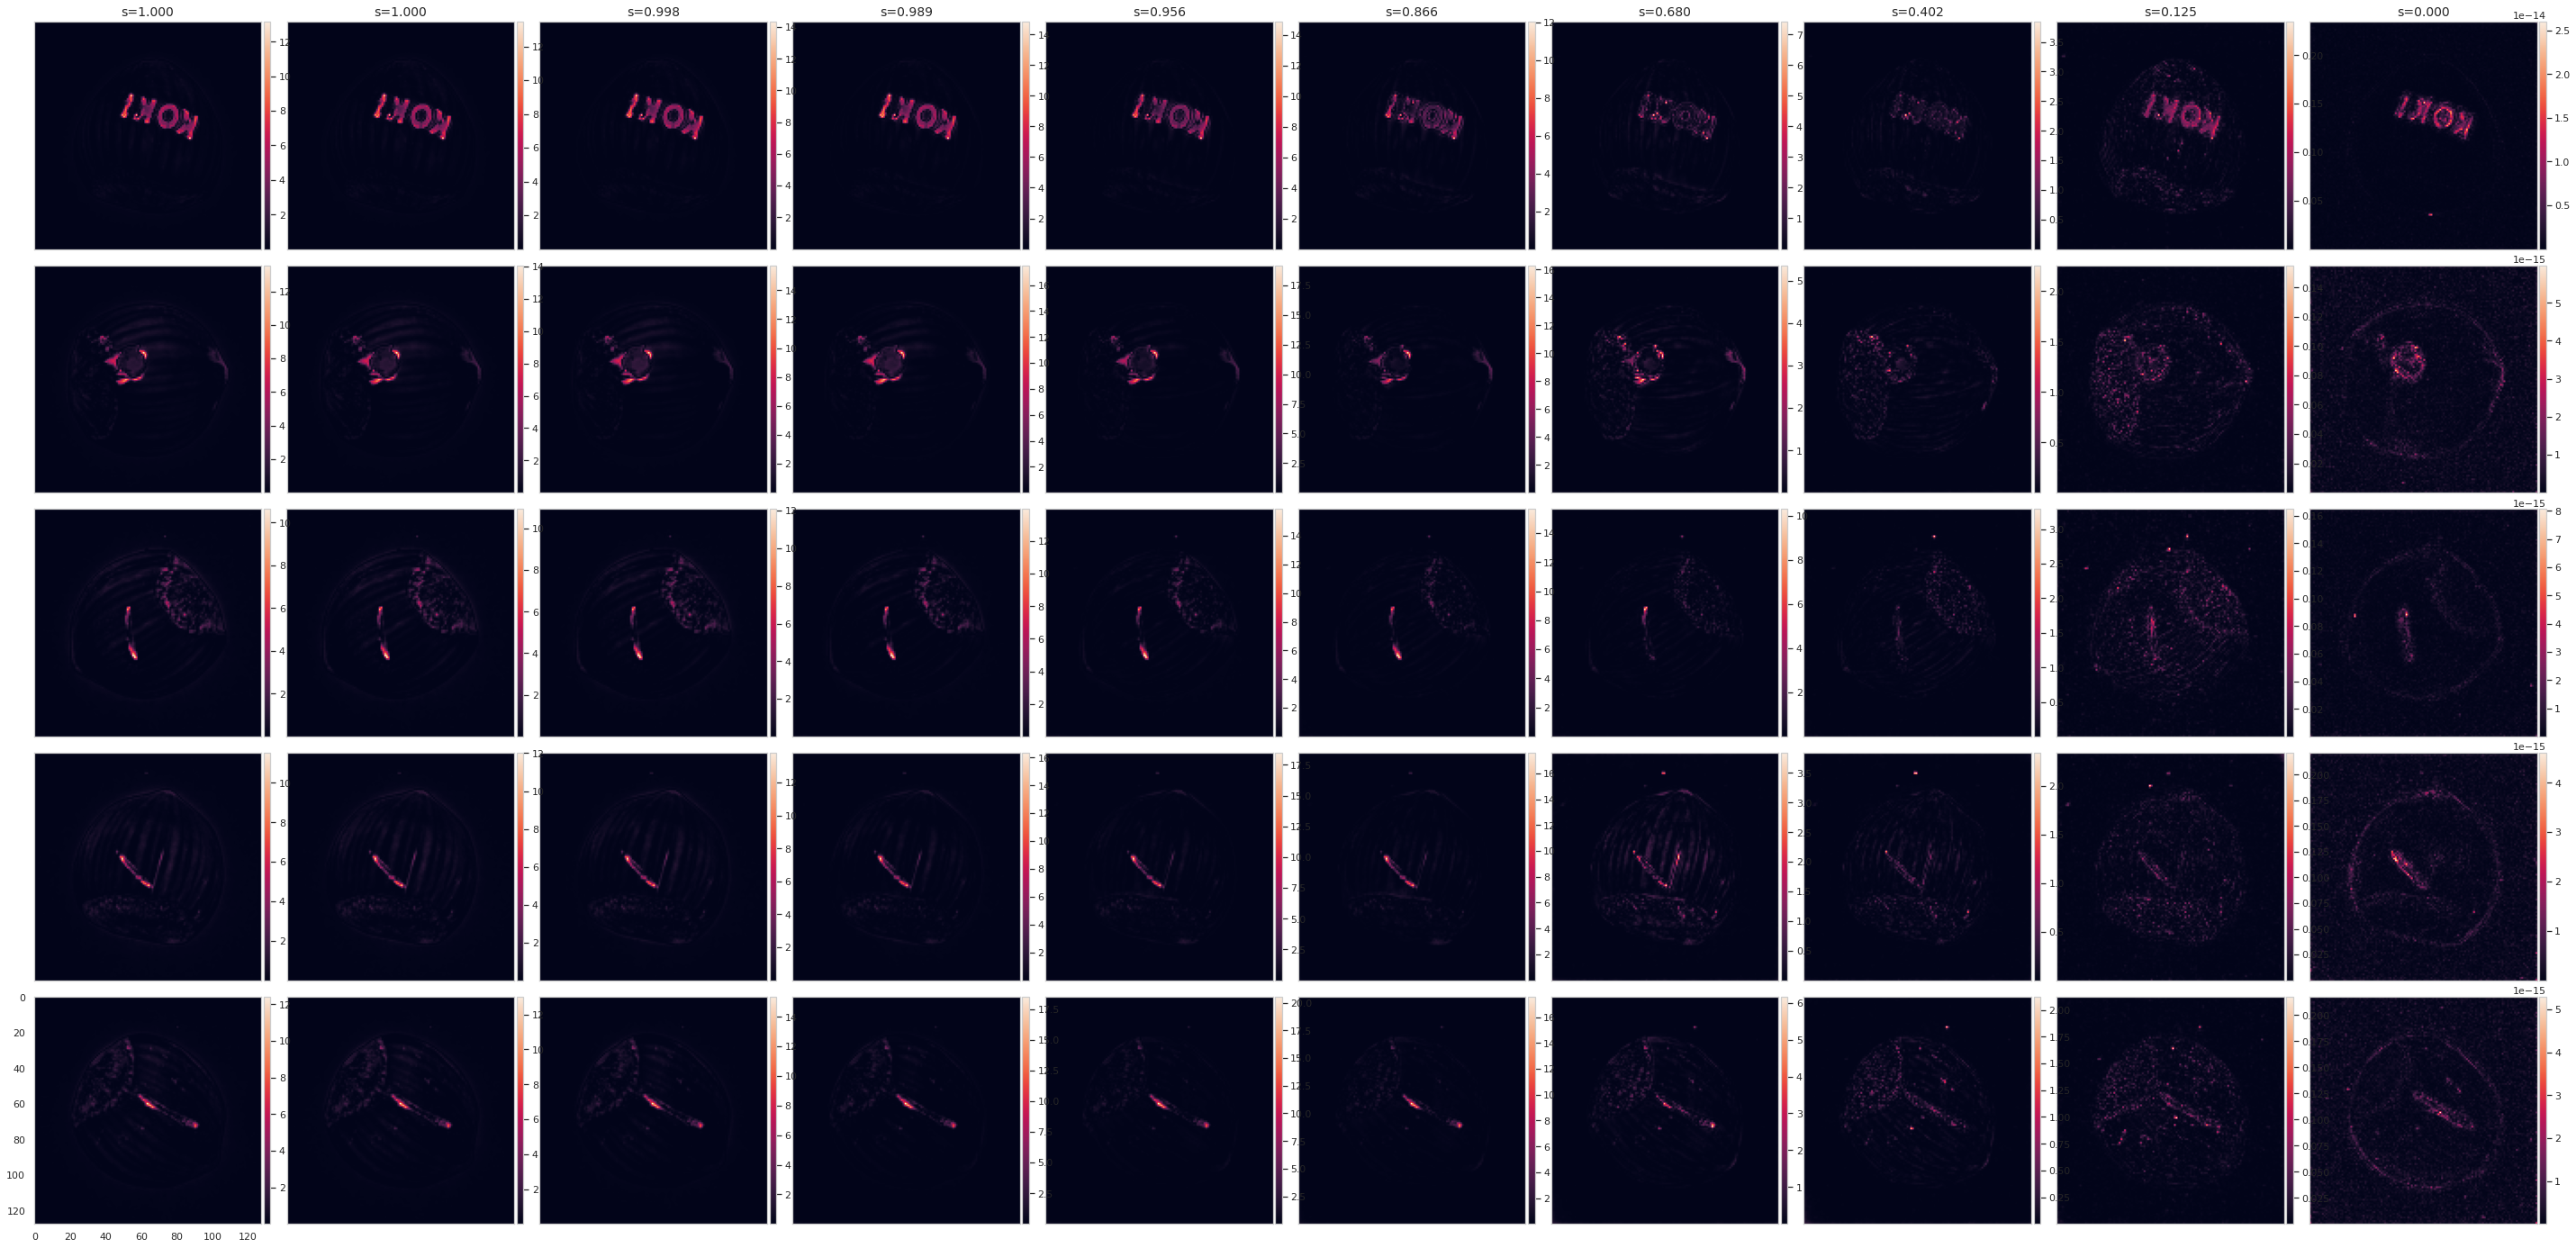

In [49]:
plot_scores(viz_ood, sigmas)

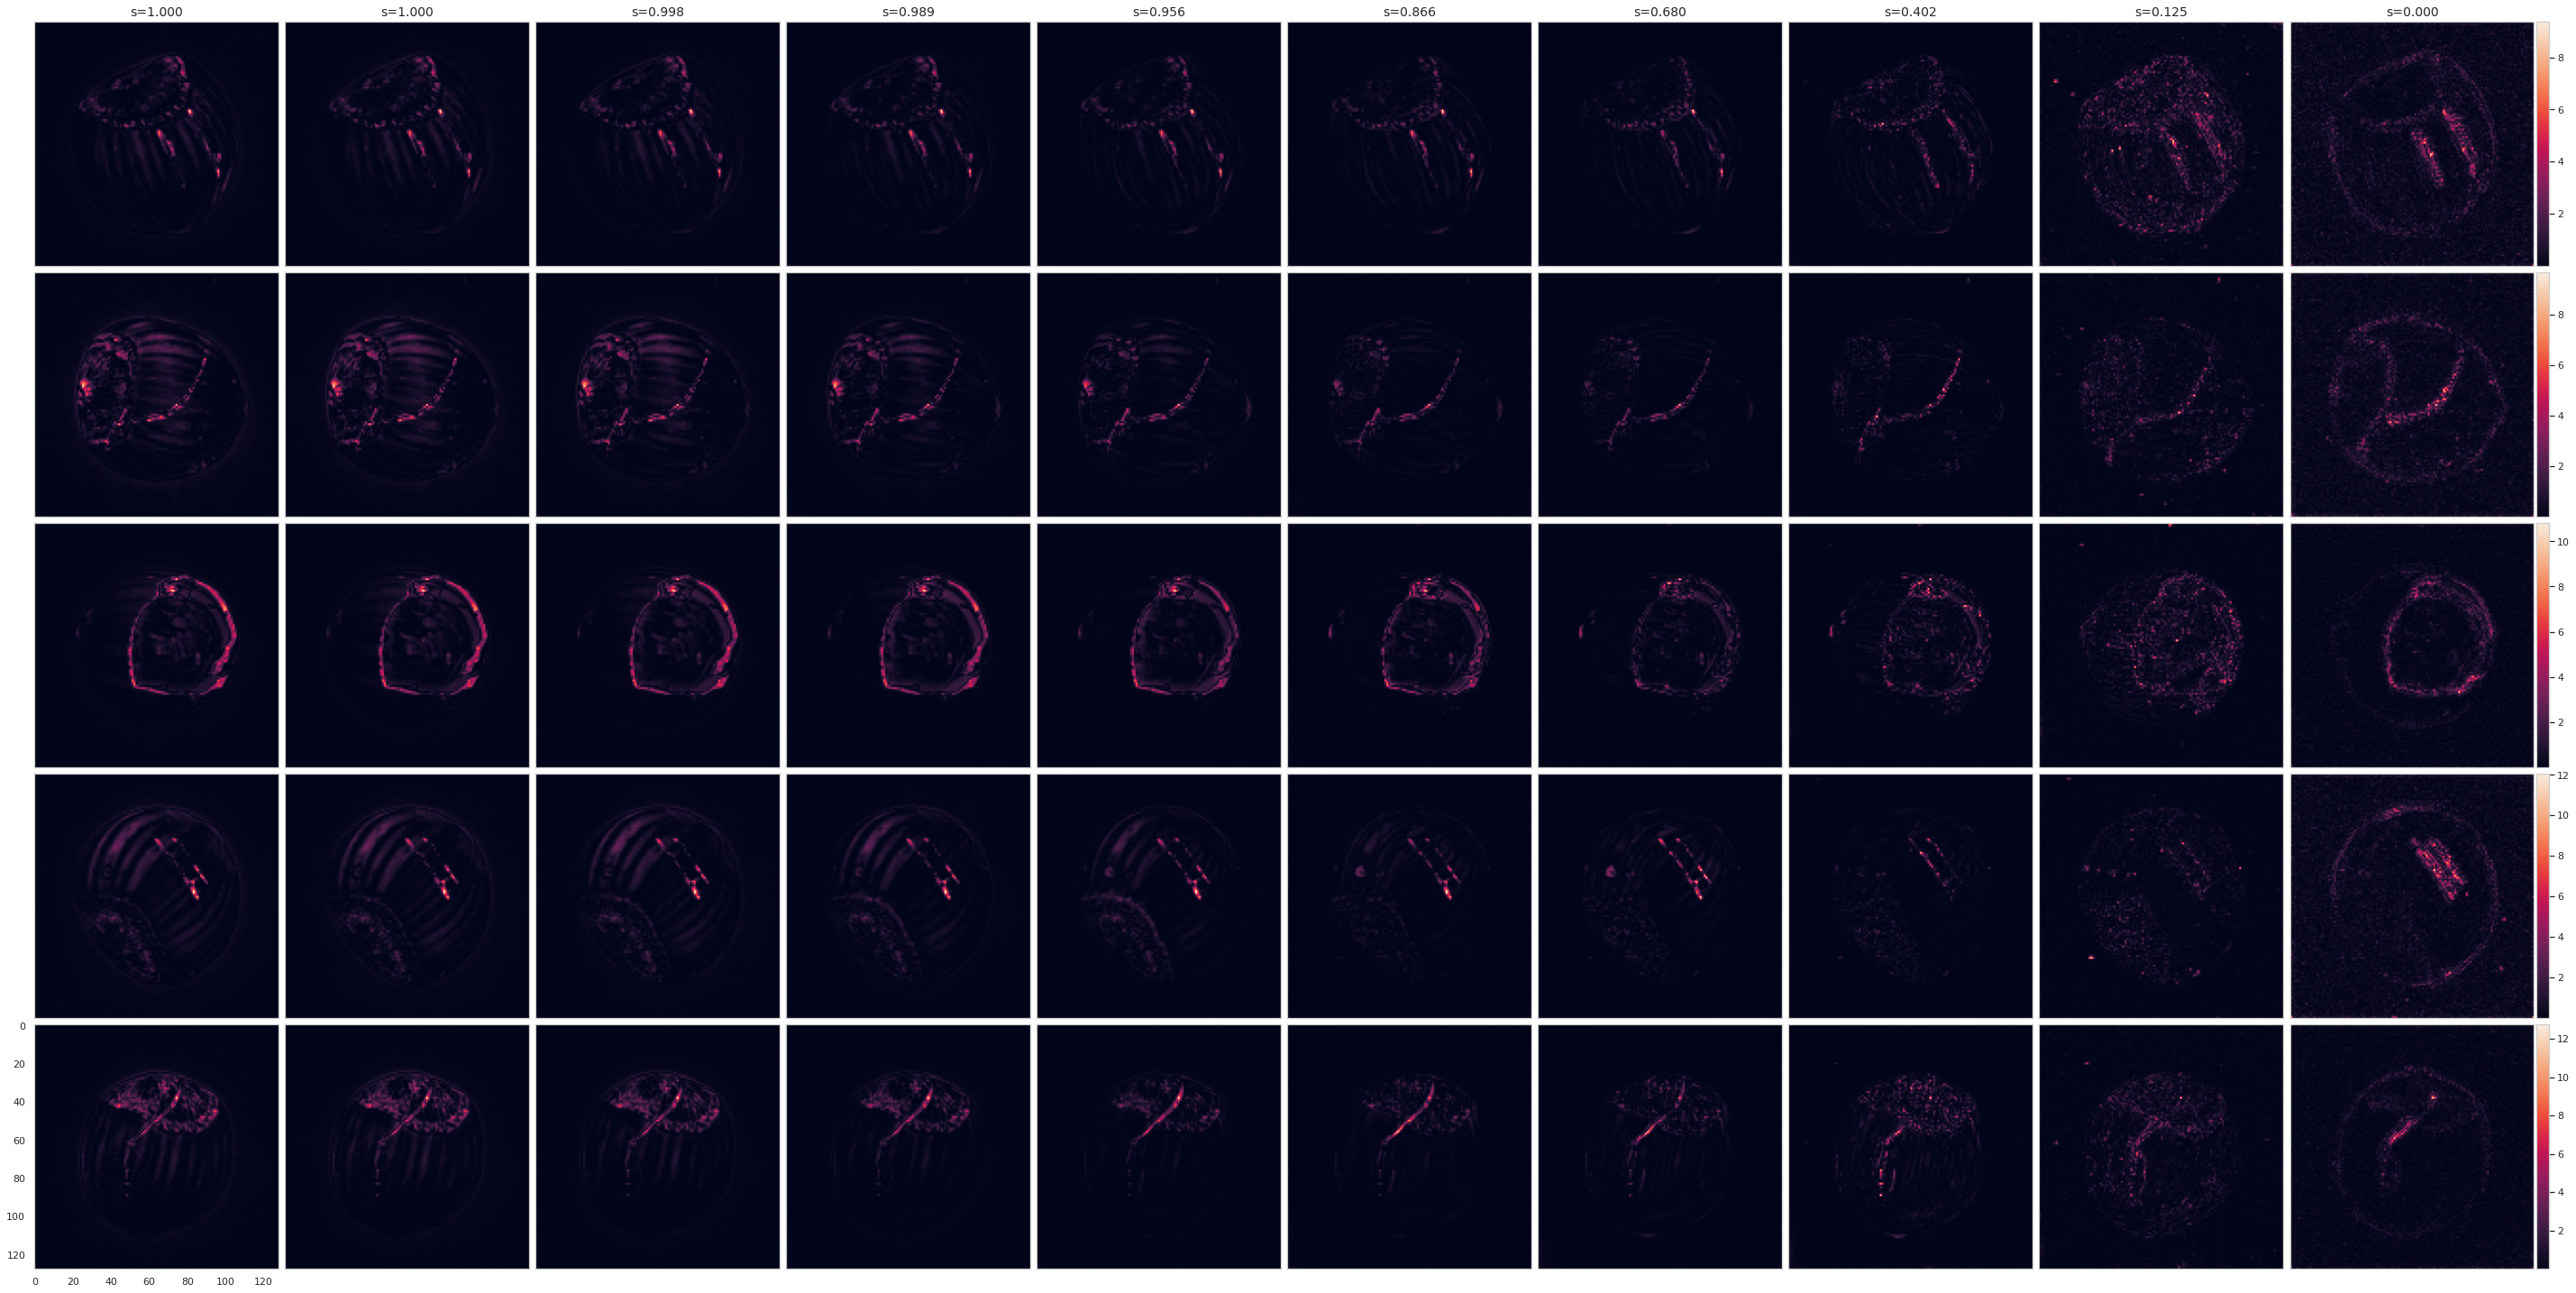

In [71]:
plot_scores(viz_ood[15:20,...], sigmas)

## MSMA

In [42]:
LABELS

['crack', 'cut', 'good', 'hole', 'print']

========================= Training GMM =========================
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -2.472892 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
-2.837288 (2.170600) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
-2.472892 (2.125774) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-2.818029 (2.270620) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
-3.278793 (3.145216) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-3.345795 (3.261463) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}


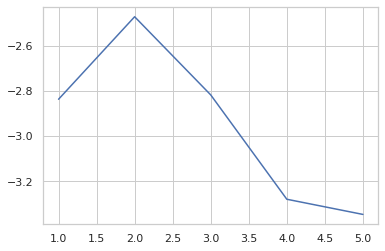

---Likelihoods---
Training: -1.454
Inlier: -1.559
OOD: -9.635
========================= Training Flow Model =========================
12/12 [==============================] - 1s 15ms/step - loss: 4156815858993201152.0000 - val_loss: 2408423046038683648.0000 - lr: 0.1000


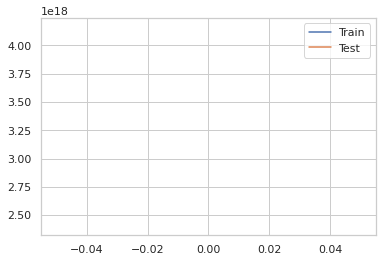

========================= Training KD Tree =========================


In [48]:
from ood_detection_helper import *

start = 0
delta = 10
end = 100

X_train = train_score_norms
# X_train = eval_score_norms.T
X_test = inlier_score_norms
X_ood = ood_score_norms
metrics = auxiliary_model_analysis(
    X_train[:, start:end:delta],
    X_test[:, start:end:delta],
    [X_ood[:, start:end:delta]],
    components_range=range(1, 6, 1),
    labels=["Train", "Inlier", "OOD"],
    flow_epochs=1,
    verbose=1
)

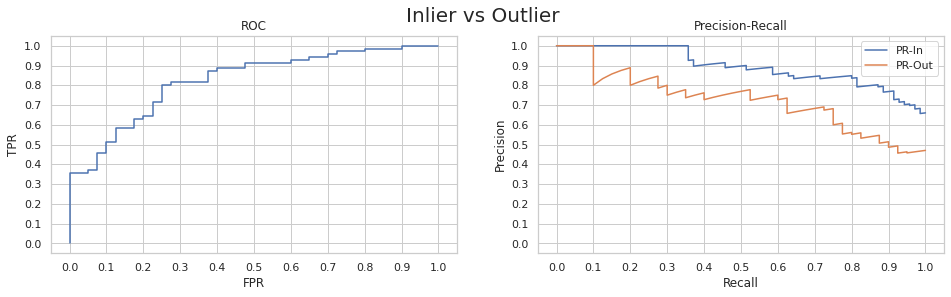

Inlier vs Outlier
----------------
ROC-AUC: 82.3214
PR-AUC (In/Out): 89.4048 / 72.4555
FPR (95% TPR): 25.00%
Detection Error: 22.50%


ap    de  fpr_tpr80  fpr_tpr95  pr_auc_in  pr_auc_out    roc_auc
OOD  89.494862  22.5       17.5       25.0  89.404847   72.455495  82.321429

In [49]:
ood_metrics(-metrics["GMM"]["test_scores"], -metrics["GMM"]["ood_scores"][0], plot=True, verbose=True)
metrics["GMM"]["metrics"]

========================= Training GMM =========================
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: 40.069356 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
---------------------------------------------------------------------------
39.693164 (10.395659) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
40.069356 (10.552633) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
36.506640 (13.244227) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
34.284227 (15.072129) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
30.920458 (16.468844) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}


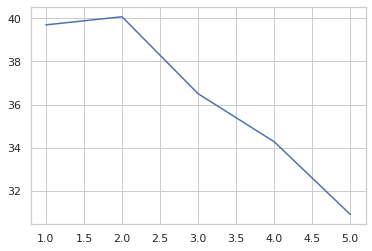

---Likelihoods---
Training: 49.361
Inlier: 24.954
OOD: -30.471
========================= Training Flow Model =========================
========================= Training KD Tree =========================


In [44]:
from ood_detection_helper import *

X_train = train_score_norms
X_test = inlier_score_norms
X_ood = ood_score_norms
metrics = auxiliary_model_analysis(
    X_train,
    X_test,
    [X_ood],
    components_range=range(1, 6, 1),
    labels=["Train", "Inlier", "OOD"],
    flow_epochs=-1,
    verbose=1
)

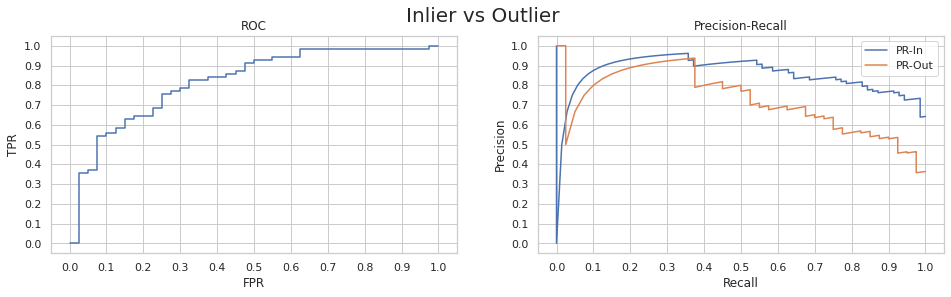

Inlier vs Outlier
----------------
ROC-AUC: 82.0000
PR-AUC (In/Out): 84.9857 / 72.2174
FPR (95% TPR): 25.00%
Detection Error: 24.64%


ap         de  fpr_tpr80  fpr_tpr95  pr_auc_in  pr_auc_out  \
OOD  85.759114  24.642857       15.0       25.0  84.985721   72.217359   

     roc_auc  
OOD     82.0

In [45]:
ood_metrics(-metrics["GMM"]["test_scores"], -metrics["GMM"]["ood_scores"][0], plot=True, verbose=True)
metrics["GMM"]["metrics"]

In [169]:
%%time
from sklearn.decomposition import FastICA

ica = FastICA(n_components=16, max_iter=10000)
X_train = ica.fit_transform(train_score_norms)
# X_inlier = ica.transform(inlier_score_norms)
# X_ood = ica.transform(ood_score_norms)
X_test = ica.transform(test_score_norms)

CPU times: user 481 ms, sys: 764 ms, total: 1.24 s
Wall time: 200 ms


In [170]:
X_train.shape, X_test.shape

((392, 16), (110, 16))

In [171]:
X_ood = [X_test[test_labels == idx] for idx in ANO_LABELS_IDX]

========================= Training GMM =========================
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best: -24.144040 using {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
---------------------------------------------------------------------------
-24.144040 (2.588830) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 1}
-24.188599 (2.562212) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
-24.672593 (2.980350) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 3}
-25.632149 (3.790546) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 4}
-26.332208 (3.691089) with: {'GMM__covariance_type': 'full', 'GMM__n_components': 5}


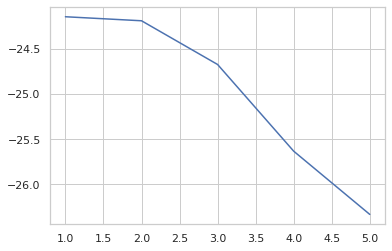

---Likelihoods---
Training: -22.703
Inlier: -23.183
crack: -41.314
cut: -30.242
hole: -27.349
print: -118.783
========================= Training Flow Model =========================
========================= Training KD Tree =========================
CPU times: user 4.64 s, sys: 8.07 s, total: 12.7 s
Wall time: 1.35 s


/ahsan_projects/score_sde_pytorch/ood_detection_helper.py:153: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  gmm_ood_scores = np.array([best_gmm_clf.score_samples(ood) for ood in outliers])


In [172]:
%%time
metrics = auxiliary_model_analysis(
    X_train,
    X_test[test_labels==INLIER_LABEL],
    X_ood,
    labels=["Train", "Inlier", *ANO_LABELS ],
    components_range=range(1, 6, 1),
    flow_epochs=-1,
)

fpr_tpr95         de    roc_auc  pr_auc_in  pr_auc_out  fpr_tpr80  \
crack       17.5  14.027778  91.944444  83.947820   96.506325        2.5   
cut         27.5  25.073529  80.294118  65.252017   90.869889       22.5   
hole        45.0  26.388889  75.277778  54.218331   87.126220       22.5   
print        0.0   9.632353  97.058824  94.676718   98.711403        0.0   

              ap  
crack  84.448501  
cut    66.518657  
hole   57.390869  
print  94.800971

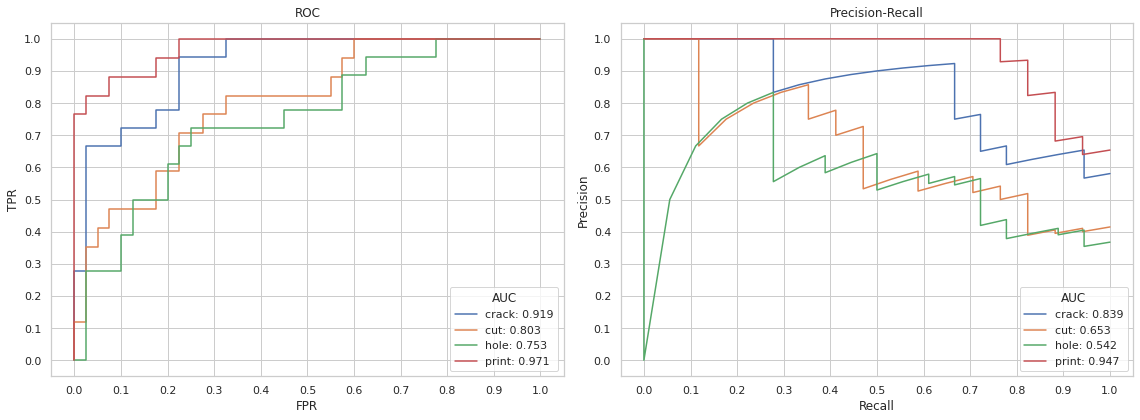

In [173]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
test_idxs = range(len(ANO_LABELS))

for idx in test_idxs:
    plot_curves(-metrics["GMM"]["test_scores"], -metrics["GMM"]["ood_scores"][idx], label=ANO_LABELS[idx], axs=axs)

for ax in axs:
    ax.legend(title="AUC")
#     ax.set(ylim=(0.7, 1.02))
plt.tight_layout()

metrics["GMM"]["metrics"]

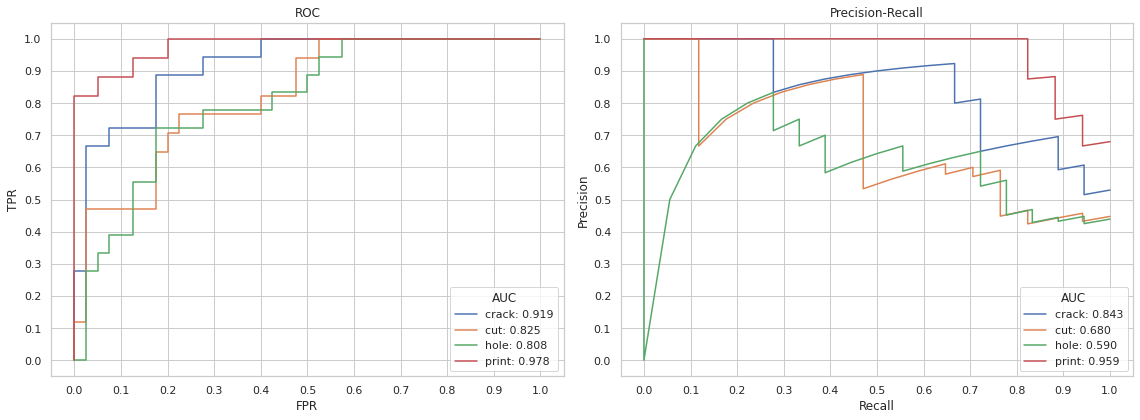

In [174]:
fig, axs = plt.subplots(1,2, figsize=(16,6))
test_idxs = range(len(ANO_LABELS))

for idx in test_idxs:
    plot_curves(metrics["KD"]["test_scores"], metrics["KD"]["ood_scores"][idx], label=ANO_LABELS[idx], axs=axs)

for ax in axs:
    ax.legend(title="AUC")
#     ax.set(ylim=(0.7, 1.02))
plt.tight_layout()

## SHAP

In [47]:
%%time
gmm = train_gmm(X_train, components_range=range(2,3))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
Best: 39.919256 using {'GMM__covariance_type': 'full', 'GMM__n_components': 2}
CPU times: user 604 ms, sys: 992 ms, total: 1.6 s
Wall time: 164 ms


In [48]:
def vectorized_score_norm_fn(x, n_timesteps = 16):
  with torch.no_grad():
    msma_sigmas = torch.linspace(eps, 1.0, n_timesteps).cuda()
    ts = list(map(noise_schedule_inverse, msma_sigmas))
    timesteps = torch.Tensor(ts).to(config.device)

    batch_sz = x.shape[0]
    # x = x.repeat(n_timesteps, 1,1,1)
    # vec_t = timesteps.repeat_interleave(batch_sz)

    x = x.repeat_interleave(n_timesteps, dim=0)
    vec_t = timesteps.repeat(batch_sz)
    # print(vec_t)
    score = score_fn(x, vec_t)
    # print("score:", score.shape)
    score = score.view(batch_sz, n_timesteps, -1)
    # print("reshaped:", score.shape)

    scores = torch.linalg.norm(score, axis=2) * msma_sigmas
  return scores

In [49]:
def score_norm_fn(x, n_timesteps =  16):
    msma_sigmas = torch.linspace(eps, 1.0, n_timesteps).cuda()
    ts = list(map(noise_schedule_inverse, msma_sigmas))
    timesteps = torch.Tensor(ts).to(config.device)
    scores = torch.zeros((x.shape[0], n_timesteps)).cuda()
    
    with torch.no_grad():
        for i in range(n_timesteps):
            t = timesteps[i]
            vec_t = torch.ones(x.shape[0], device=config.device) * t
            score = score_fn(x, vec_t)
            scores[..., i] = torch.linalg.norm(
                              score.reshape(x.shape[0], -1),
                              axis=1)
    return scores * msma_sigmas

In [304]:
N_TIMESTEPS

32

In [328]:
def msma_fn(x, chunk_sz=4,):
  
  if isinstance(x, np.ndarray):
    if x.ndim == 3:
        x = np.expand_dims(x, axis=0)
    x = x.astype(np.float32)
    x = scaler(torch.from_numpy(x)).to(config.device).float()
    x = x.permute(0, 3, 1, 2)
#     x = load_sample(x)
  
  batch_sz = x.shape[0]
  
  scores = np.zeros((batch_sz, N_TIMESTEPS), dtype=np.float32)

  for i in range(0, batch_sz, chunk_sz):
    scores[i:i+chunk_sz, ...] = vectorized_score_norm_fn(
          x[i:i+chunk_sz], n_timesteps=N_TIMESTEPS
    ).cpu().numpy()

  log_prob = gmm.score_samples(scores)
  
  return log_prob

In [52]:
train_ds, test_ds, seg_ds = build_ds_loaders(128, 128, bs=128)

Found 392 files belonging to 1 classes.
Found 110 files belonging to 5 classes.
Found 70 files belonging to 4 classes.


In [53]:
x_test_imgs, test_labels = next(iter(test_ds))
x_test_imgs = x_test_imgs.numpy()
test_labels = test_labels.numpy()

In [54]:
x_test_imgs.shape

(110, 128, 128, 3)

In [55]:
X_ood_imgs = x_test_imgs[test_labels != INLIER_LABEL]
X_inlier_imgs = x_test_imgs[test_labels == INLIER_LABEL]

array([50.64364362])

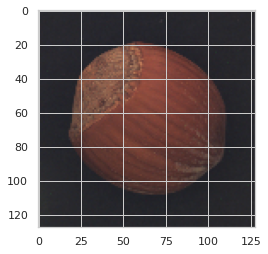

In [61]:
plt.imshow(X_inlier_imgs[0])
msma_fn(X_inlier_imgs[1])

array([-15.70640178])

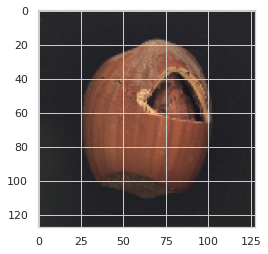

In [62]:
plt.imshow(X_ood_imgs[0])
msma_fn(X_ood_imgs[:1])

In [63]:
%%time
inlier_scores = msma_fn(X_inlier_imgs)
anomaly_scores = msma_fn(X_ood_imgs)

CPU times: user 7.5 s, sys: 18.5 s, total: 26 s
Wall time: 22.4 s


Average Inlier Likelihood: 25.280


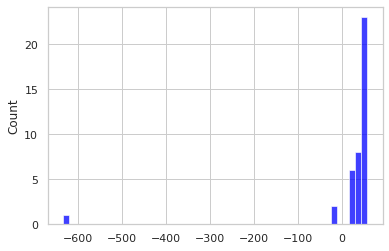

In [64]:
sns.histplot(inlier_scores, color="blue", label="Inliers", bins=50)
print(f"Average Inlier Likelihood: {inlier_scores.mean():.3f}")

Average OOD Likelihood: -30.498


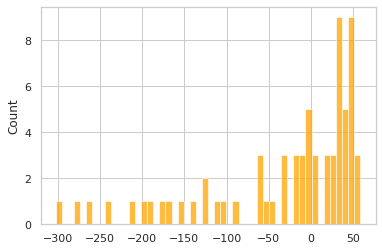

In [65]:
sns.histplot(anomaly_scores, color="orange", label="Outliers", bins=50)
print(f"Average OOD Likelihood: {anomaly_scores.mean():.3f}")

In [66]:
worst_idxs = np.argsort(anomaly_scores)
worst_idxs[0]

61

In [365]:
worst_idxs[25]

45

(<matplotlib.image.AxesImage at 0x7fc177431b80>, -17.396598320106)

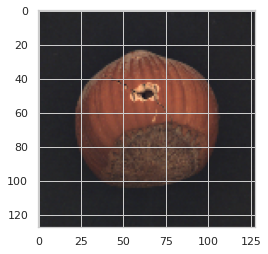

In [367]:
plt.imshow(X_ood_imgs[worst_idxs[25]]), anomaly_scores[worst_idxs[25]]

In [153]:
import shap
from skimage.segmentation import slic
import matplotlib.pylab as pl

def fill_segmentation(values, segmentation):
    out = np.zeros(segmentation.shape)
    for i in range(len(values)):
        out[segmentation == i] = values[i]
    return out

# make a color map
from matplotlib.colors import LinearSegmentedColormap
colors = []
for l in np.linspace(1,0,100):
    colors.append((245/255,39/255,87/255,l))
for l in np.linspace(0,1,100):
    colors.append((24/255,196/255,93/255,l))
cm = LinearSegmentedColormap.from_list("shap", colors)

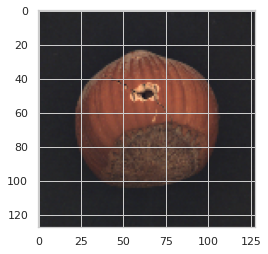

((128, 128), 64)

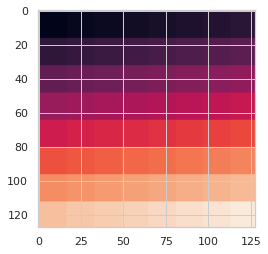

In [442]:
img = X_ood_imgs[worst_idxs[25]] #worst_idx
n_patches_max = 64

# segment the image so we don't have to explain every pixel
segments_slic = slic(img, n_segments=n_patches_max, compactness=1000, sigma=3)
n_patches = segments_slic.max()
plt.imshow(img)
plt.show()
plt.imshow(segments_slic)
segments_slic.shape, n_patches

In [443]:
# define a function that depends on a binary mask representing if an image region is hidden
'''
Expects and returns channel-last images
'''
def mask_image(zs, segmentation, image, background=None):
    if background is None:
        background = image.mean()
    out = np.zeros(
        (zs.shape[0], image.shape[0], image.shape[1], image.shape[2]),
        dtype=np.float32
    )
    for i in range(zs.shape[0]):
        out[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                out[i][segmentation == j, :] = background
    return out

In [389]:
log_prob = msma_fn(img)

In [390]:
%%time
# use Kernel SHAP to explain the network's predictions
def f(z):
    return msma_fn(mask_image(z, segments_slic, img, None))

explainer = shap.KernelExplainer(f, np.zeros((1,n_patches)))
shap_values = explainer.shap_values(np.ones((1,n_patches)), nsamples=2048) # runs N times

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 45.5 s, sys: 2min 52s, total: 3min 38s
Wall time: 3min 32s


Expected Null Likelihood: -7851.346
Total Contribution: 7833.422
Sample Log Likelihood: -17.924
(128, 128) (128, 128, 3) (128, 128, 1)


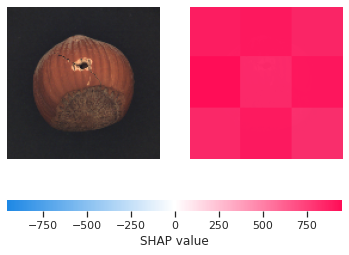

In [392]:
print(f"Expected Null Likelihood: {explainer.expected_value:.3f}")
print(f"Total Contribution: {np.sum(shap_values):.3f}")
print(f"Sample Log Likelihood: {log_prob[0]:.3f}")

m = fill_segmentation(shap_values[0], segments_slic)
s = np.expand_dims(m, axis=-1)
print(m.shape, img.shape, s.shape)

# output with shap values
shap.image_plot(s, img)

### Climb scores

In [395]:
import controllable_generation
from sampling import (ReverseDiffusionPredictor, 
                      LangevinCorrector, 
                      EulerMaruyamaPredictor, 
                      AncestralSamplingPredictor, 
                      NoneCorrector, 
                      NonePredictor,
                      AnnealedLangevinDynamics)

sde.N = 1000

predictor = EulerMaruyamaPredictor #@param ["EulerMaruyamaPredictor", "AncestralSamplingPredictor", "ReverseDiffusionPredictor", "None"] {"type": "raw"}
corrector = None #@param ["LangevinCorrector", "AnnealedLangevinDynamics", "None"] {"type": "raw"}
snr = 0.0
n_steps = 1 # Number of corrector updates
probability_flow = False

pc_inpainter = controllable_generation.get_pc_inpainter(sde,
                                                        predictor, corrector,
                                                        inverse_scaler,
                                                        snr=snr,
                                                        n_steps=n_steps,
                                                        probability_flow=probability_flow,
                                                        continuous=config.training.continuous,
                                                        denoise=True)

In [77]:
X_ood_masks, ood_labels = next(iter(seg_ds))

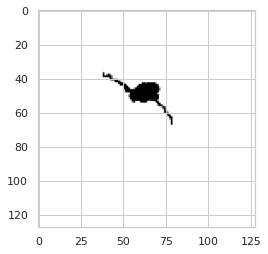

In [396]:
plt.imshow(1-X_ood_masks[worst_idxs[25]])

In [406]:
img = X_ood_imgs[worst_idxs[25]]
mask = X_ood_masks[worst_idxs[25]]
x_img = load_sample(img)
x_mask = 1.0 - load_sample(mask, scale=False) 

In [398]:
%%time
x = pc_inpainter(score_model, x_img, x_mask)

CPU times: user 28.8 s, sys: 85.4 ms, total: 28.9 s
Wall time: 28.9 s


In [399]:
x.shape

torch.Size([1, 3, 128, 128])

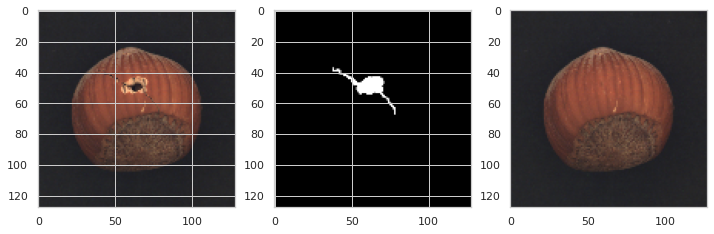

In [402]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(X_ood_imgs[worst_idxs[25]])
axs[1].imshow(X_ood_masks[worst_idxs[25]])
axs[2].imshow(x[0].permute(1,2,0).cpu())
plt.grid(False)

In [131]:
config.model.num_scales, sde.N

(2000, 2000)

### Lower number of steps

In [472]:
sde.N = 1000
pc_inpainter = controllable_generation.get_pc_inpainter(
    sde,
    predictor, corrector,
    inverse_scaler,
    snr=snr,
    n_steps=n_steps,
    probability_flow=probability_flow,
    continuous=config.training.continuous,
    denoise=True)

In [473]:
%%time
x = pc_inpainter(score_model, x_img, x_mask)

CPU times: user 28.3 s, sys: 86.7 ms, total: 28.4 s
Wall time: 28.4 s


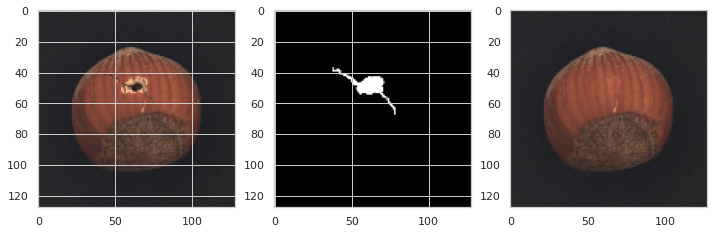

In [474]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img)
axs[1].imshow(mask)
axs[2].imshow(x[0].permute(1,2,0).cpu())
plt.grid(False)

In [475]:
msma_fn(x_img), msma_fn(scaler(x))

(array([-17.92418999]), array([44.38310425]))

In [476]:
%%time
x1 = pc_inpainter(score_model, x_img, torch.from_numpy(segments_slic!=1).type(torch.float32).cuda())

CPU times: user 28.2 s, sys: 73.2 ms, total: 28.3 s
Wall time: 28.3 s


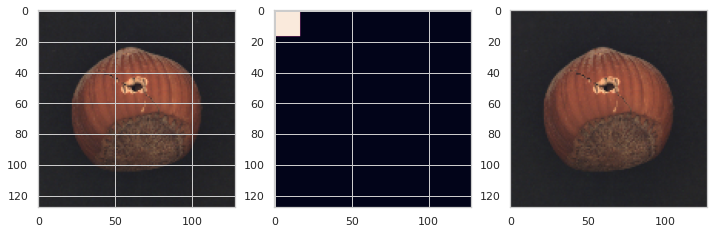

In [477]:
fig, axs = plt.subplots(1,3, figsize=(12,4))
axs[0].imshow(img)
axs[1].imshow(segments_slic==1)
axs[2].imshow(x1[0].permute(1,2,0).cpu())
plt.grid(False)

In [479]:
msma_fn(scaler(x1))

array([-17.9383717])

In [480]:
# define a function that depends on a binary mask representing if an image region is hidden
def mask_image_score(zs, segmentation, image, chunk_sz=128):
    '''
    mask: 0-1 tensor. Value `1` marks known pixels,
        and value `0` marks pixels that require inpainting.
    '''

    if np.sum(zs) == 0.0:
        return X_inlier_imgs[0] #surrogate inlier as baseline
    
    background = 0.0
    img = torch.zeros(
        (zs.shape[0], image.shape[0], image.shape[1], image.shape[2]),
        dtype=torch.float32
    )
    for i in range(zs.shape[0]):
        img[i,:,:,:] = image
        for j in range(zs.shape[1]):
            if zs[i,j] == 0:
                img[i][:, segmentation == j] = background
    
    img = img.cuda()
    mask = (img != background).type(torch.float32)
#     print(img.shape)
#     batch_sz = img.shape[0]

    out =  pc_inpainter(score_model, img, mask)
    return scaler(out)

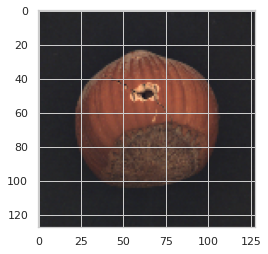

In [481]:
IDX = 25

img_orig = load_sample(X_ood_imgs[worst_idxs[IDX]])

def f(z, chunk_sz=128):
    
#     print(z.shape)
    if np.sum(z) == 0.0:
        return np.expand_dims(np.median(inlier_scores), axis=0) #surrogate inlier as baseline
    
    
    out_ll = np.zeros(z.shape[0])
    
    for i in tqdm(range(0, z.shape[0], chunk_sz)):
        x_input = mask_image_score(z[i:i+chunk_sz], segments_slic, img_orig[0])
        out_ll[i:i+chunk_sz] = msma_fn(x_input)
        
    return out_ll

plt.imshow(X_ood_imgs[worst_idxs[IDX]])

In [482]:
%%time
explainer = shap.KernelExplainer(f, np.zeros((1,n_patches)))
print(f"Expected Null Likelihood: {explainer.expected_value:.3f}")

Expected Null Likelihood: 47.672
CPU times: user 1.09 ms, sys: 236 µs, total: 1.33 ms
Wall time: 1.11 ms


In [ ]:
%%time
shap_values = explainer.shap_values(np.ones((1,n_patches)), nsamples=3000) # runs N times

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

In [ ]:
log_prob = msma_fn(img)
log_prob

Expected Null Likelihood: 47.672
Total Contribution: -65.747
Sample Log Likelihood: -17.924


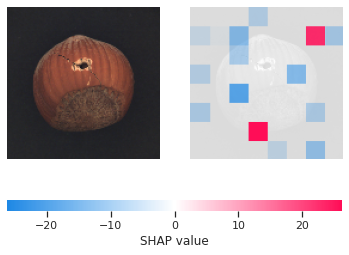

In [485]:
print(f"Expected Null Likelihood: {explainer.expected_value:.3f}")
print(f"Total Contribution: {np.sum(shap_values):.3f}")
print(f"Sample Log Likelihood: {log_prob[0]:.3f}")

m = fill_segmentation(shap_values[0], segments_slic)
s = np.expand_dims(m, axis=-1)
# print(m.shape, img.shape, s.shape)

# output with shap values
shap.image_plot(s, img)

Expected Null Likelihood: 47.672
Total Contribution: -66.133
Sample Log Likelihood: -17.924


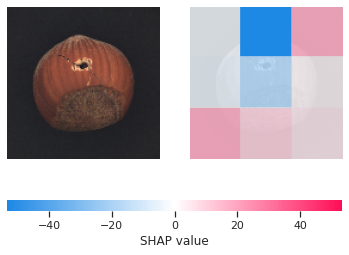

In [438]:
print(f"Expected Null Likelihood: {explainer.expected_value:.3f}")
print(f"Total Contribution: {np.sum(shap_values):.3f}")
print(f"Sample Log Likelihood: {log_prob[0]:.3f}")

m = fill_segmentation(shap_values[0], segments_slic)
s = np.expand_dims(m, axis=-1)
# print(m.shape, img.shape, s.shape)

# output with shap values
shap.image_plot(s, img)

Expected Null Likelihood: 53.103
Total Contribution: -353.789
Sample Log Likelihood: -300.335


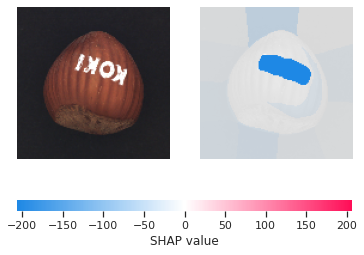

In [349]:
print(f"Expected Null Likelihood: {explainer.expected_value:.3f}")
print(f"Total Contribution: {np.sum(shap_values):.3f}")
print(f"Sample Log Likelihood: {log_prob[0]:.3f}")

m = fill_segmentation(shap_values[0], segments_slic)
s = np.expand_dims(m, axis=-1)
# print(m.shape, img.shape, s.shape)

# output with shap values
shap.image_plot(s, img)

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.


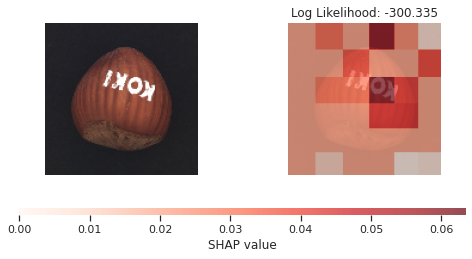

In [280]:
# plot our explanations
fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(8,4))
# inds = top_preds[0]
img =  X_ood_imgs[worst_idxs[0]]#inverse_scaler(img_orig[0].cpu().permute(1,2,0))
axes[0].imshow(img)
axes[0].axis('off')

# Temperature scaled softmax
T=100
x = -shap_values[0]
softmax_shap = np.exp(x/T)/np.sum(np.exp(x/T))

for i in range(1):
    m = fill_segmentation(softmax_shap, segments_slic)
    axes[i+1].set_title(f"Log Likelihood: {log_prob[0]:.3f}")
    axes[i+1].imshow(img, alpha=0.8, cmap="gray")
    im = axes[i+1].imshow(m, cmap="Reds", vmin=0, vmax=None, alpha=0.7)
    axes[i+1].axis('off')
cb = fig.colorbar(im, ax=axes.ravel().tolist(), label="SHAP value", orientation="horizontal", aspect=60)
cb.outline.set_visible(False)
pl.show()

### Partition 